In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from PIL import Image
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

In [4]:
def show_uint8(img_uint8, figsize = (8, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(img_uint8.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


In [6]:
# Load models and class names
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).eval()

COCO_CLASSES = weights.meta["categories"]
len(COCO_CLASSES), COCO_CLASSES[:15]

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/chamu/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [05:59<00:00, 466kB/s]  


(91,
 ['__background__',
  'person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'N/A',
  'stop sign',
  'parking meter'])

In [ ]:
# Detection runner
@torch.no_grad()
def detect_boxes(
    image_path,
    targets=("car", "traffic light"),
    threshold=0.7,
    width=4
):
    target_ids = [COCO_CLASSES.index(t) for t in targets]

    img = Image.open(image_path).convert("RGB")
    x = T.ToTensor()(img).unsqueeze(0) # [1, C, H, W] -> to indicate the batch size (of 1), ie one img

    pred = model(x)[0] # Taking the info from just the first (and only element), type(pred) = dict
    # pred.keys() = ['boxes', 'labels', 'scores'], can have some other stuff for other models
    
    boxes, labels, scores = pred["boxes"], pred["labels"], pred["scores"] # (N, 4), (N, ), (N, ), where N is the #obj identified
    # and 4 is the apprx region (xmin, xmax) and (ymin, ymax) for an obj 

    keep = torch.zeros_like(scores, dtype=torch.bool) # (N, )

    for i in range(scores.shape[0]):
        if (labels[i].item() in target_ids) and (scores[i].item() >= threshold):
            keep[i] = True 

    img_uint8 = (T.ToTensor()(img) * 255).byte() # Prepare img for drawing by converting the (0, 1) tensor -> (0, 255) torch.uint8 

    if keep.sum().item() == 0:
        print("No detections above threshold")
        return img_uint8 
    
    boxes_k = boxes[keep] 
    labels_k = labels[keep]
    scores_k = scores[keep]
    draw_labels = [f"{COCO_CLASSES[l.item()]} {s.item():.2f}" for l, s in zip(labels_k, scores_k)]

    out = vutils.draw_bounding_boxes(img_uint8, boxes_k, labels=draw_labels, width=width) # return type uint8 (tensor img)
    return out


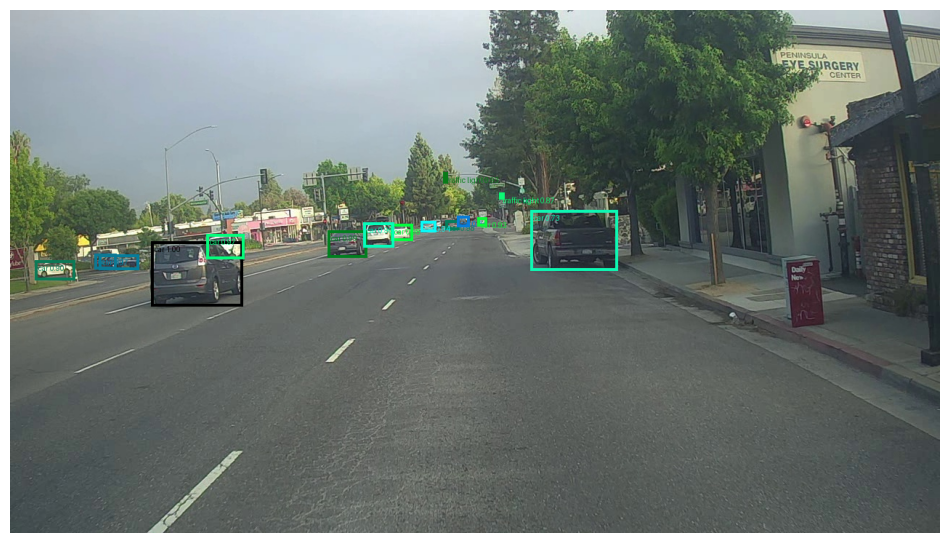

In [14]:
image_path = "/Users/chamu/vesuvius-scroll-detection/images/sandbox/cars.jpg"
out = detect_boxes(image_path, targets=("car","traffic light"), threshold=0.7, width=4)
show_uint8(out, figsize=(12,12))

Threshold =  0.3


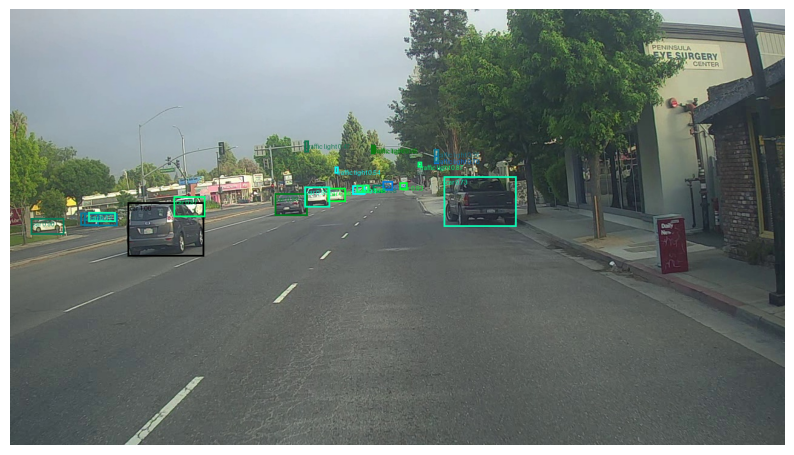

Threshold =  0.5


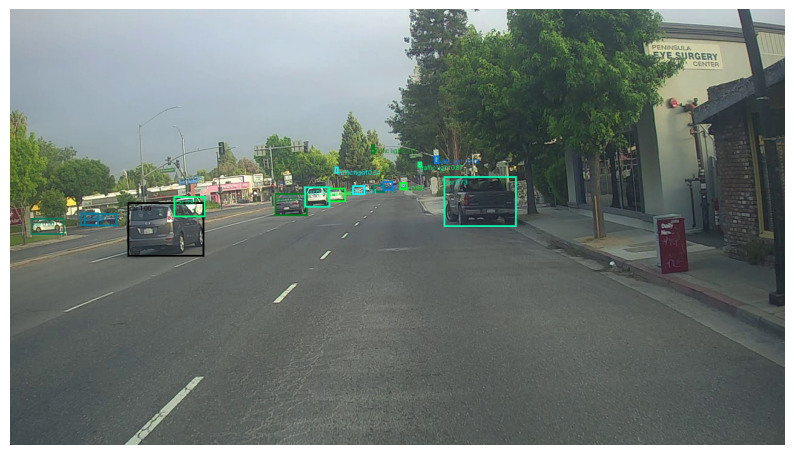

Threshold =  0.7


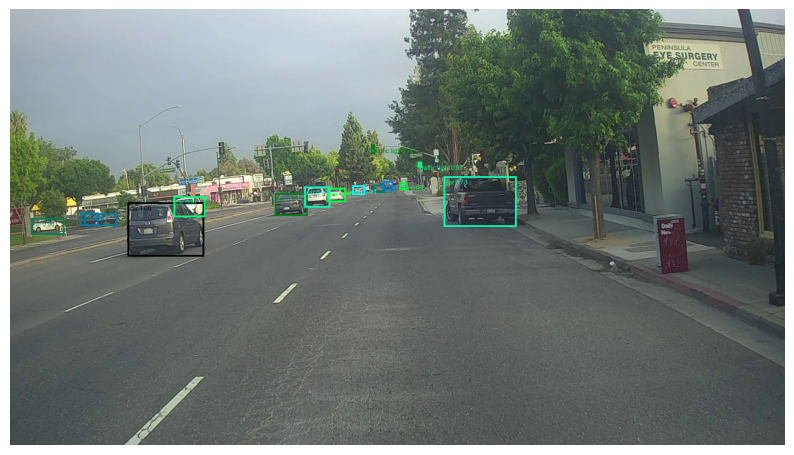

Threshold =  0.9


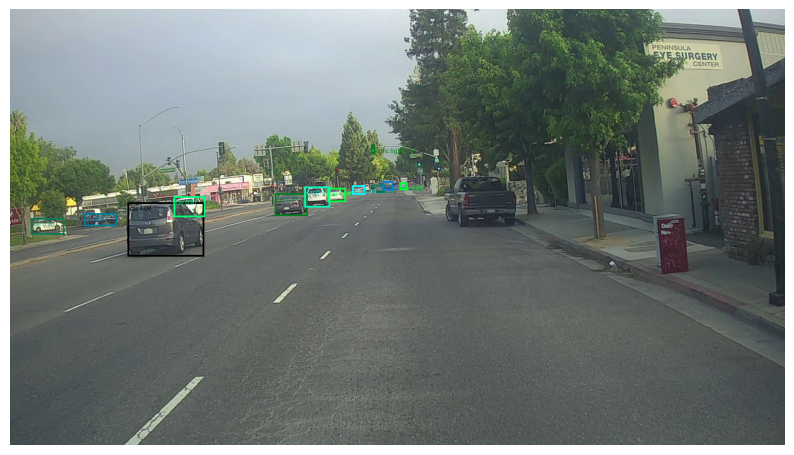

In [15]:
for thr in [0.3, 0.5, 0.7, 0.9]:
    print("Threshold = ", thr)
    out = detect_boxes(image_path, targets=("car","traffic light"), threshold=thr, width=3)
    show_uint8(out, figsize=(10, 10))